<a href="https://colab.research.google.com/github/jayasurya21/Unamzer-Assessment/blob/main/Airbnb_Austin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Airbnb_Austin**

Airbnb is the place that connects the people who want to rent out their homes with people who are looking for accommodations in that locale, here we have Airbnb Austin data and we will be exploring some great visualization and facts, stay tuned.


## **Importing Libraries**

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [45]:
!pip install geopandas

In [46]:
#For interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap


## **Loading the data**

In [47]:
listings = pd.read_csv("/content/drive/MyDrive/Austin/listings.csv", index_col= "id")

In [48]:
print(listings.shape)

(10272, 15)


In [49]:
print("No. of null values:\n",listings.isna().sum())

No. of null values:
 name                                  0
host_id                               0
host_name                             5
neighbourhood_group               10272
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                        2600
reviews_per_month                  2600
calculated_host_listings_count        0
availability_365                      0
dtype: int64


We have our listing data which has 15 features as mentioned above and 10272 records, last_review, review per months have some values unless we try to analyse the review let’s continue without dropping any records for maximum utilizations

# **Task1**
 
Now we will make something interesting from the data, yes visualization, we will plot a bar graph for most listed neighbourhoods in austin.


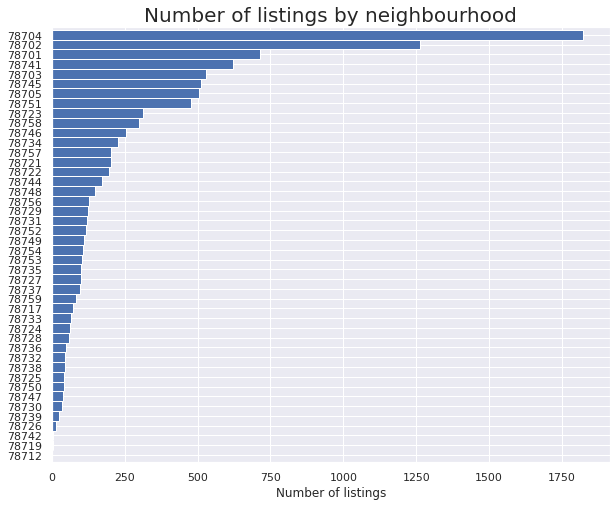

In [50]:
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

From the above graph we can clearly see the most listings by neighbourhood and we have 78704 with most listings(78704 is zipcode of the neighbourhood,where 78704 is located in the state of Texas in the Austin metro area)

Below I've have plotted an interactive map for the total number of listings in a neighbourhood, feel free to explore it.

In [51]:
listings = listings.drop(columns=['neighbourhood_group'])

In [52]:
t = listings[listings["neighbourhood"]==78704]
t = t.iloc[0]
L = [t['latitude'],t['longitude']]
print(L)

[30.2463, -97.76361]


In [53]:
latitudelist = listings['latitude'].tolist()
longitudelist = listings['longitude'].tolist()
locations = list(zip(latitudelist, longitudelist))
Thematic_map = folium.Map(location=[L[0],L[1]], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(Thematic_map)
Thematic_map


In [54]:
Thematic_map.save("T1_listing by neighbourhood.html")


# **Task2**
let's try exploring something unique, let's build a thematic map for neighbourhood by single room or entire home


In [55]:
listings['room_type'].unique()


array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

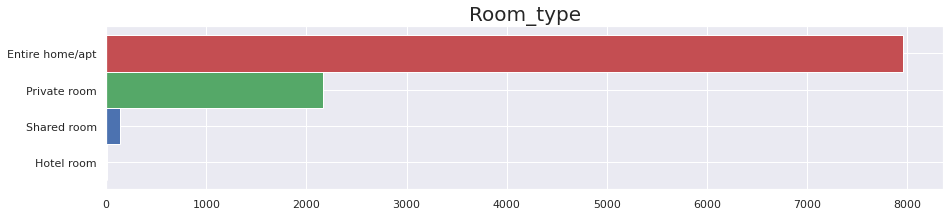

In [56]:
Room_type = listings['room_type']. value_counts().sort_values(ascending=True)
Room_type.plot.barh(figsize=(15, 3), width=1, color = ["r","b","g"])
plt.title("Room_type", fontsize = 20)
plt.show()

In Austin data we have 4 categories of room type Entire home/apt', 'Private room', 'Hotel room', 'Shared room' and from above graph we can say that entire home/apt are mostly listed so it's hard to get a single room at Austin

I've considered shared room,hotel room and private room as single room and constructed a thematic map below

In [57]:
feq = listings[['neighbourhood',"room_type"]]
feq['room_type'] = feq['room_type'].apply(lambda x: x if x == 'Entire home/apt' else "single room")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [58]:
feq = feq.groupby(['neighbourhood',"room_type"])['room_type'].count() \
                  .unstack(fill_value=0)\
                  .rename_axis(None, axis=1)
feq.head()
feq.dtypes

Entire home/apt    int64
single room        int64
dtype: object

In [59]:
feq['total'] = feq['Entire home/apt'] + feq['single room']

In [60]:
adam = gpd.read_file("/content/drive/MyDrive/Austin/neighbourhoods.geojson")
adam['neighbourhood']= adam['neighbourhood'].astype("int64")
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
map_dict = adam.set_index('neighbourhood')['total'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map3 = folium.Map(location=[30.269501, -97.715942], zoom_start=11)
folium.GeoJson(data=adam,
               name='Austin',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'Entire home/apt','single room'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

From the map it's clear that more rooms/appartments are available at center(like 78704,78702) than at borders

In [73]:
map3.save("Task_2.html")

# **Task 3**
Here I will be displaying the the top 10 hosts who have made listed 

In [62]:
hosts = listings.groupby('host_id').host_id.count()

In [63]:
hosts = hosts.sort_values(ascending=False)

In [64]:
hosts = hosts.iloc[:10]

In [65]:
names = []

In [66]:
for i in range(len(hosts)):
 names.append(listings[listings['host_id']==hosts.index[i]].host_name.iloc[0])

In [67]:
names

['Kia',
 'WanderJaunt',
 'TurnKey Vacation Rentals',
 'Martin',
 'Renters Club',
 'Madalynn',
 'Christian',
 'Above',
 'Kia',
 'Lodgewell']

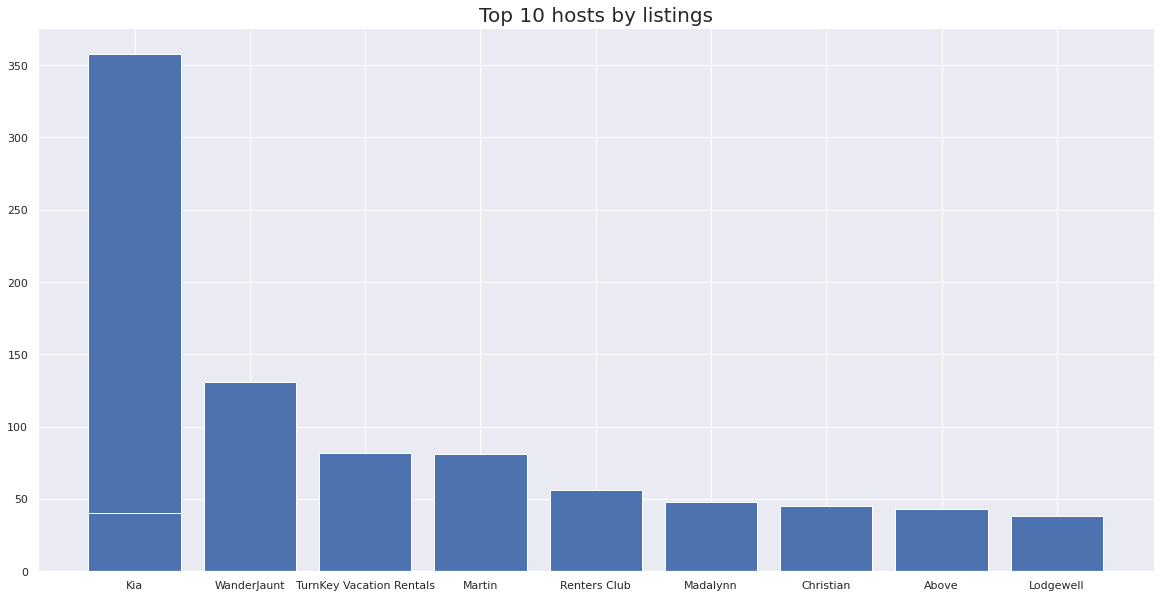

In [68]:
fig = plt.figure(figsize=(20,10))
plt.bar(names,hosts)
plt.title("Top 10 hosts by listings",fontsize = 20)
plt.show()

From the bar graph above we can conclude that kia have made most of the listings 353, and we can the rest 9 top listers 

### **Let's do more visualization**

First I will import the csv file which conatins the detailed listing details and merge it with the one that already present 

In [69]:
listings_details = pd.read_csv("/content/drive/MyDrive/Austin/listings_det.csv",index_col= "id", low_memory=False)
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10272 entries, 2265 to 48111525
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            10272 non-null  object 
 1   host_id                         10272 non-null  int64  
 2   host_name                       10267 non-null  object 
 3   neighbourhood                   10272 non-null  int64  
 4   latitude                        10272 non-null  float64
 5   longitude                       10272 non-null  float64
 6   room_type                       10272 non-null  object 
 7   price                           10272 non-null  int64  
 8   minimum_nights                  10272 non-null  int64  
 9   number_of_reviews               10272 non-null  int64  
 10  last_review                     7672 non-null   object 
 11  reviews_per_month               7672 non-null   float64
 12  calculated_host_listings_c

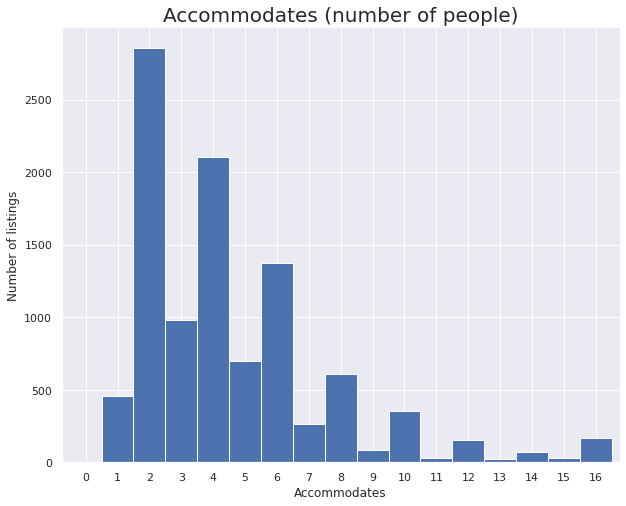

In [70]:
feq=listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

From the above graph we can tell that apparments or rooms that listed are majority of 2 members accommodation, So let's find out averge Listings price for 2 members accommodation for each neighbourhood.

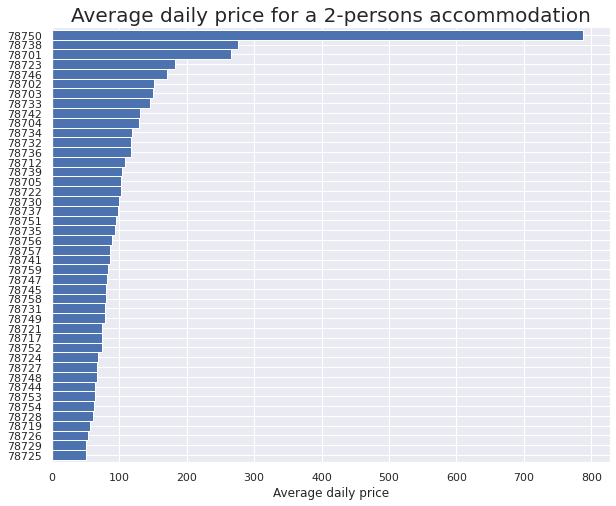

In [71]:
feq = listings[listings['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price', fontsize=12)
plt.ylabel("")
plt.show()

The above graph plots the average listing price for each neighbourhood which accommodates 2 members and area 78750 seems expensive since it's in the core of the city

# **What is super host?**
Superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests.

Once a host reaches Superhost status, a badge superhost badge will automatically appear on their listing and profile to help you identify them.

We check Superhosts’ activity four times a year, to ensure that the program highlights the people who are most dedicated to providing outstanding hospitality.

So let's see the proportion pf super host in Austin.. 

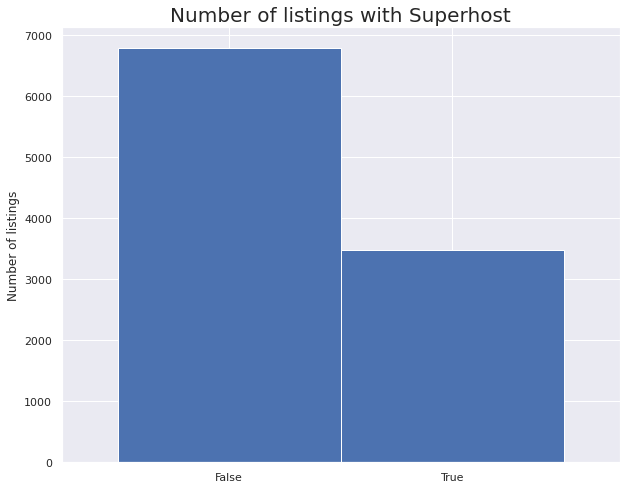

In [72]:
listings.host_is_superhost = listings.host_is_superhost.replace({"t": "True", "f": "False"})

feq=listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

Looks like Austing have 25% of their hosts has superhost good for customers :)